In [61]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd
import json_reader
from region_extractor import extract_region
from knn import clean_noise
import os
#from sklearn.neural_network import MLPRegressor
import math
import tqdm
%matplotlib inline


In [62]:
def feature_scaling(scaler,examples):
    examples = scaler.fit_transform(examples)
    return examples


def data_transform(features,target):

    print(features.shape)
    min_max_scaler = preprocessing.MinMaxScaler()
    features = feature_scaling(min_max_scaler,features)
    X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                        test_size=0.33,
                                                        random_state=42)
    return (X_train, X_test, y_train, y_test)

In [63]:
def linear_fit(data_frame):
    lr_model = linear_model.LinearRegression()
    #lr_model= MLPRegressor(max_iter=350)
    model = lr_model.fit(data_frame[0],data_frame[2])
    predictions=model.predict(data_frame[1])
    
    RMSE = round(mean_squared_error(data_frame[3],predictions),3)
    score = round(model.score(data_frame[1],data_frame[3]),3)
    
    plt.scatter(predictions,data_frame[3],alpha = .75, color = 'b')
    plt.xlabel('pridict_value')
    plt.ylabel('actual_value')
    plt.show()

    print('RMSE is: %.3f'%RMSE)
    print("Score is: %f"%score)
    print('Coefficients: \n', model.coef_)


In [64]:
property_type_set = ["end terrace","terraced","semi-detached","detached","mews house",
"flat",
"maisonette",
"bungalow",
"town house",
"cottage",
"farm",
"barn",
"mobile",
"static",
"land",
"studio", 
"block of flats", "office"]
    
house_type_set = ["end terrace","terraced","semi-detached","detached","flat"]
    
import geopy.distance
from random import shuffle

def prepareTrainingdata(region_houses_list,sale_type,estimate_type):
    house_distance_set = []
    price_difference_set = []
    shuffle(region_houses_list)
    count = 0
    for i, house_info in enumerate(region_houses_list):
        if house_info['price'] == -1 or house_info['property_type'] not in house_type_set:
            continue
        count+=1
        if count == len(region_houses_list)/2:
            break
        clip = region_houses_list[i+1:len(region_houses_list)]
        shuffle(clip)
        clip = clean_noise(clip,150,house_type_set)
        for index, house in clip[:round(len(clip.index)/2)].iterrows():
            #if house["price"] ==-1 or house["num_bed"]<0 or house_info['property_type'] not in house_type_set:
            #    continue
            geo_dis = geopy.distance.vincenty(house["coordinate"],house_info["coordinate"]).m
            if geo_dis>5000:
                continue
            house_d_features = []
            price_difference_ratio = math.sqrt((house["price"] - house_info["price"])**2)/house["price"]
            if price_difference_ratio >8:
                continue
            for feature in train_features:
                if feature == "coordinate":
                    house_d_features.append(geo_dis)
                else:
                    house_d_features.append(squareDiffer(house[feature],house_info[feature]))
            house_distance_set.append(house_d_features)
            price_difference_set.append(price_difference_ratio)
    examples= pd.DataFrame(house_distance_set)
    examples.columns = train_features
    
    labels = pd.DataFrame(price_difference_set)
    labels.columns = ["price_diff_ratio"]
    concat_data = pd.concat([examples,labels],ignore_index = True,axis = 1)
    sample = concat_data.sample(frac = 0.3)
    
    #print(labels.describe())
    return sample


In [65]:
def single_feature(examples,targets):
    for i in examples.columns:
        data = examples[i].reshape(-1,1)
        print(data.shape)
        data_frame = data_transform(data,targets)
        linear_fit(data_frame)
        
        

In [66]:
def squareDiffer(x1,x2):
    return (x1-x2)**2
    
"""
def extract_region(postcode):
        postcode_split = postcode.split()
        region  = self.pattern.search(postcode_split[1]).group(0)
        return region
"""

'\ndef extract_region(postcode):\n        postcode_split = postcode.split()\n        region  = self.pattern.search(postcode_split[1]).group(0)\n        return region\n'

In [67]:
train_features = ["num_bath","num_bed","month_view","coordinate"]

regions_data = []
path = "./sale_region/"
region_list  =os.listdir(path) 
if ".DS_Store" in region_list:
    region_list.remove(".DS_Store")
from tqdm import tqdm

for region in tqdm(region_list[:2]):
    print(region)
    region_houses_list = list(json_reader.json_read(path,region)[0].values())[0]
    if len(region_houses_list)<=1:
        continue
    region_df = prepareTrainingdata(region_houses_list,"rent","rent")
    
    regions_data.append(region_df)
    
regions_data = pd.concat(regions_data, ignore_index =True)


#linear_fit(data_frame)

  0%|          | 0/2 [00:00<?, ?it/s]

SL.json


 50%|█████     | 1/2 [05:06<05:06, 306.06s/it]

BS.json


100%|██████████| 2/2 [07:34<00:00, 227.45s/it]


In [41]:
regions_data.columns = train_features+["price_diff_ratio"]

In [56]:
examples = regions_data[train_features]
target = pd.DataFrame(regions_data["price_diff_ratio"])
print(target.head())

TypeError: list indices must be integers or slices, not list

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


(314985, 1)
(314985, 1)


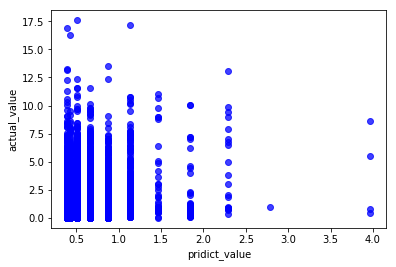

RMSE is: 0.471
Score is: 0.025000
Coefficients: 
 [[ 3.57336565]]
(314985, 1)
(314985, 1)


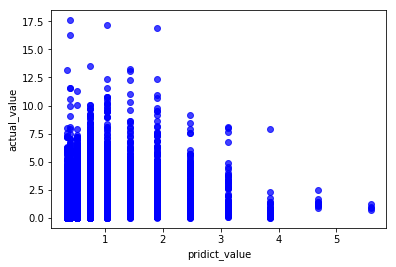

RMSE is: 0.414
Score is: 0.143000
Coefficients: 
 [[ 5.23860737]]
(314985, 1)
(314985, 1)


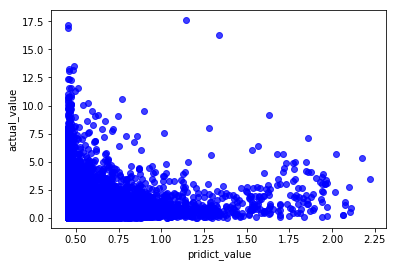

RMSE is: 0.476
Score is: 0.014000
Coefficients: 
 [[ 1.76410133]]
(314985, 1)
(314985, 1)


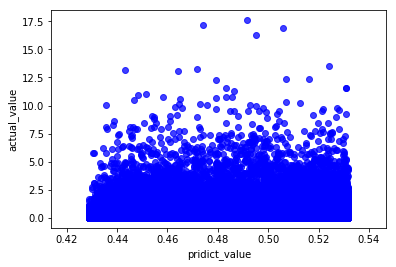

RMSE is: 0.482
Score is: 0.001000
Coefficients: 
 [[ 0.10294156]]
(314985, 4)


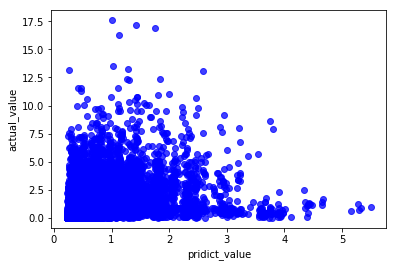

RMSE is: 0.403
Score is: 0.165000
Coefficients: 
 [[ 2.48009166  4.92444674  1.5740725   0.07122766]]


In [52]:

single_feature(examples,target)
data_frame = data_transform(examples,target)
linear_fit(data_frame)